In [1]:
# standard libraries
import os
import csv
import random
import timeit
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image

# scikit-learn libraries
from sklearn.metrics import (
    roc_curve, 
    auc,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

# pytorch libraries
import torch
from torch import cat
from torch import no_grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# qiskit libraries
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.primitives import StatevectorEstimator as Estimator

In [2]:
base_dir = '../../../../datasets/MNIST/4v5'
to_pil = transforms.ToPILImage()

def is_mnist_already_saved(base_dir):
    return os.path.exists(base_dir) and any(os.scandir(base_dir))

if is_mnist_already_saved(base_dir):
    print("Data already exists at", base_dir)
else:
    train_dataset = datasets.MNIST(root='./data', train=True, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True)

    def save_images(dataset, split='train', classes_to_save=[2,3], sample_frac=0.1):
        filtered_indices = [i for i, (_, label) in enumerate(dataset) if label in classes_to_save]
        sample_size = int(len(filtered_indices) * sample_frac)
        sampled_indices = set(random.sample(filtered_indices, sample_size))

        for idx, (image, label) in enumerate(dataset):
            if idx not in sampled_indices:
                continue
            
            label_dir = os.path.join(base_dir, split, str(label))
            os.makedirs(label_dir, exist_ok=True)

            if isinstance(image, torch.Tensor):
                image = to_pil(image)

            image.save(os.path.join(label_dir, f"{idx}.png"))

    save_images(train_dataset, 'train')
    save_images(test_dataset, 'test')

    print("Sampled ~10% of MNIST 4 and 5 images saved as PNGs!")

    shutil.rmtree('./data', ignore_errors=True)
    print("Deleted ./data directory after saving images.")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:05<00:00, 1.89MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 115kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.03MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<?, ?B/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Sampled ~10% of MNIST 4 and 5 images saved as PNGs!
Deleted ./data directory after saving images.


In [3]:
# Set parameters
BATCH_SIZE = 16
IMAGE_SIZE = 28
LEARNING_RATE = 0.001
EPOCHS = 5
NUM_OF_QUBITS = 2

In [4]:
class CustomDataset(Dataset):
    def __init__(self, base_path, image_size, mode):
        self.image_tensors = []
        self.labels = []

        # Set random seed for reproducibility
        random.seed(42)

        # Define transformations: resize to 128x128 and convert to tensor
        self.transform = transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToTensor()])
        
        # Define the label mapping
        self.label_mapping = {
            '2': 0,
            '3': 1
        }

        # Load images and labels
        self.load_images(base_path, image_size, mode)

    def load_images(self, base_path, image_size, mode):
        total_images = sum([len([img for img in os.listdir(os.path.join(base_path, class_name)) if img.endswith(('png', 'jpg', 'jpeg'))]) 
                            for class_name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, class_name))])

        # Create a tqdm progress bar for the overall process
        with tqdm(total=total_images, desc=f"Loading and processing {mode} images", position=0, ncols=100) as pbar:
            # Loop through each class folder
            for class_name in os.listdir(base_path):
                class_path = os.path.join(base_path, class_name)
                if os.path.isdir(class_path) and class_name in self.label_mapping:
                    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('png', 'jpg', 'jpeg'))]
                    
                    # Load and convert images to tensors
                    for img_path in images:
                        image = Image.open(img_path).convert('L')  # Convert to grayscale
                        if self.transform:
                            image = self.transform(image)  # Apply transformations
                        self.image_tensors.append(image)
                        self.labels.append(self.label_mapping[class_name])  # Use the mapped label
                        pbar.update(1)  # Update the progress bar after each image

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, idx):
        return self.image_tensors[idx], self.labels[idx]

In [5]:
train_path = '../../../../datasets/MNIST/4v5/train'
test_path = '../../../../datasets/MNIST/4v5/test'

# Create dataset instances
train_dataset = CustomDataset(train_path, IMAGE_SIZE, mode='train')
test_dataset = CustomDataset(test_path, IMAGE_SIZE, mode='test')

Loading and processing test images: 100%|████████████████████████| 204/204 [00:01<00:00, 200.05it/s]


In [6]:
# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=int(BATCH_SIZE/4), shuffle=True)

# Example usage
for images, labels in train_loader:
    print(images.shape)  # Shape of the images tensor
    print(labels)        # Shape of the labels tensor
    break                # Just to check the first batch

torch.Size([16, 1, 28, 28])
tensor([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0])


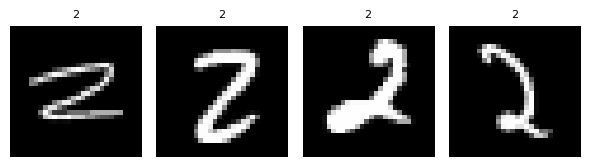

In [7]:
samples = 4

indices = [50, 100, 150, 200]

fig, axes = plt.subplots(1, 4, figsize=(6, 3))
axes = axes.flatten()

for ax, idx in zip(axes, indices):
    image, label = train_dataset[idx]
    ax.imshow(image.squeeze(0), cmap='gray')  # Remove channel dimension for display
    ax.set_title(f'{list(train_dataset.label_mapping.keys())[label]}', fontsize='8')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Define and create QNN
def create_qnn(n_qubits):
    
    feature_map = ZZFeatureMap(n_qubits)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    
    qc = QuantumCircuit(n_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    estimator = Estimator()
    
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        estimator=estimator
    )
    return qnn, qc

qnn, qc = create_qnn(NUM_OF_QUBITS)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


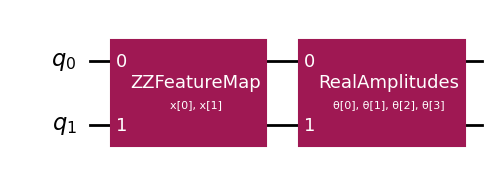

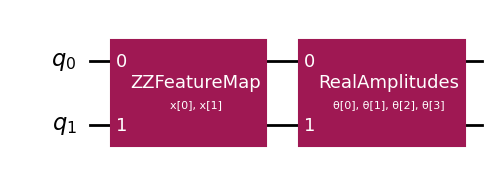

In [9]:
qc.draw(output="mpl")

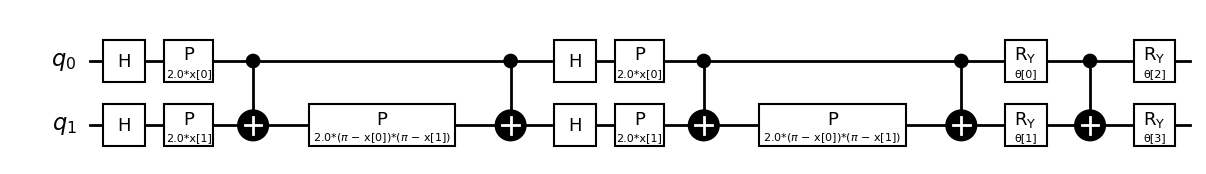

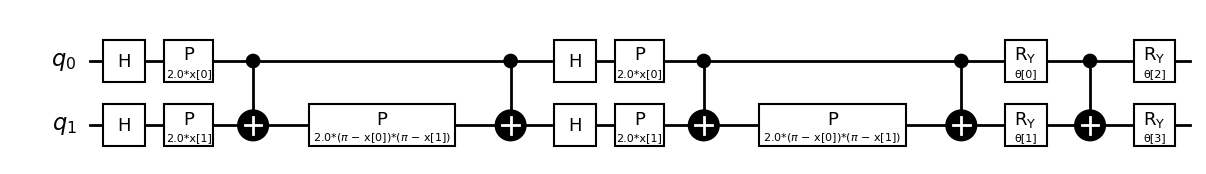

In [10]:
qc.decompose().draw(output="mpl", style="bw")

In [11]:
class Net(nn.Module):
    def __init__(self, qnn, image_size, n_qubits):
        super().__init__()
        self.image_size = image_size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=24, kernel_size=5)
        self.dropout = nn.Dropout2d()
        
        # Compute the size of the feature map after convolutions and pooling
        size_after_conv1 = (image_size - 5 + 1) // 2  # kernel=5, stride=1, pool=2
        size_after_conv2 = (size_after_conv1 - 5 + 1) // 2  # kernel=5, stride=1, pool=2
        
        # Calculate the flattened size for fc2
        self.flattened_size = 24 * size_after_conv2 * size_after_conv2
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, n_qubits)  
        self.qnn = TorchConnector(qnn)
        self.fc3 = nn.Linear(1, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        x = cat((x, 1 - x), -1)
        return x

model = Net(qnn, IMAGE_SIZE, NUM_OF_QUBITS)

In [12]:
summary(model, (1, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 24, 24]              52
            Conv2d-2             [-1, 24, 8, 8]           1,224
         Dropout2d-3             [-1, 24, 4, 4]               0
            Linear-4                  [-1, 128]          49,280
            Linear-5                    [-1, 2]             258
    TorchConnector-6                    [-1, 1]               4
            Linear-7                    [-1, 1]               2
Total params: 50,820
Trainable params: 50,820
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.19
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [13]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_func = nn.CrossEntropyLoss()  

In [14]:
# Callback classes/functions
class ReduceLROnPlateau:
    def __init__(self, optimizer, factor=0.7, patience=3, min_lr=1e-6, verbose=1):
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.best_loss = float('inf')
        self.wait = 0

    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                for param_group in self.optimizer.param_groups:
                    new_lr = max(param_group['lr'] * self.factor, self.min_lr)
                    param_group['lr'] = new_lr
                if self.verbose:
                    print(f"Reducing learning rate to {new_lr:.6f}")
                self.wait = 0

class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', save_best_only=True, mode='min'):
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.mode = mode
        self.best = float('inf') if mode == 'min' else -float('inf')

    def step(self, val_loss):
        if self.save_best_only:
            if (self.mode == 'min' and val_loss < self.best) or (self.mode == 'max' and val_loss > self.best):
                self.best = val_loss
                torch.save(model.state_dict(), self.filepath)

class CSVLogger:
    def __init__(self, filename):
        self.filename = filename
        with open(self.filename, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

    def log(self, epoch, train_loss, train_accuracy, val_loss, val_accuracy):
        with open(self.filename, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch, train_loss, train_accuracy, val_loss, val_accuracy])

In [15]:
# Instantiate callbacks
callbacks = [
    ReduceLROnPlateau(optimizer),
    ModelCheckpoint(filepath=os.path.abspath('../../../../models/classification/control/mnist/mnist_4v5_2qubits_r1.pt')),
    CSVLogger(os.path.abspath('../../../../models/classification/control/mnist/mnist_4v5_2qubits_r1.csv'))
]

In [16]:
# Training parameters
train_loss_list = []  # Store training loss history
train_accuracy_list = []  # Store training accuracy history
val_loss_list = []  # Store validation loss history
val_accuracy_list = []  # Store validation accuracy history
best_accuracy = 0  # Best accuracy tracker

# Print table header
print(f"{'Epoch':<10}{'Train Loss':<15}{'Train Accuracy':<20}{'Val Loss':<15}{'Val Accuracy':<20}")
print("="*72)

# Start training
start = timeit.default_timer()  # Total training start time

# Start training
for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    
    total_loss = []
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        
        # Forward pass
        output = model(data)  # Use model for prediction
        loss = loss_func(output, target)  # Calculate loss
        
        # Backward pass
        loss.backward()
        optimizer.step()  # Optimize weights
        
        total_loss.append(loss.item())  # Store loss
        
        # Calculate training accuracy
        predicted = output.argmax(dim=1)  # Get predicted class
        correct_predictions += (predicted == target).sum().item()  # Count correct predictions
        total_samples += target.size(0)  # Count total samples
    
    # Calculate average training loss and accuracy
    avg_loss = sum(total_loss) / len(total_loss)
    training_accuracy = 100 * correct_predictions / total_samples
    train_loss_list.append(avg_loss)
    train_accuracy_list.append(training_accuracy)
    
    model.eval()  # Set model to evaluation mode
    
    accuracy = 0
    total_val_loss = []
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)  # Use model for validation
            
            # Calculate validation loss
            val_loss = loss_func(output, target)
            total_val_loss.append(val_loss.item())
            
            # Calculate validation accuracy
            predicted = output.argmax(dim=1)  # Get predicted class
            accuracy += (predicted == target).sum().item()  # Count correct predictions
        
        # Calculate average validation loss and accuracy
        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        val_accuracy = 100 * accuracy / len(test_loader.dataset)
        val_accuracy_list.append(val_accuracy)
        
        # Callbacks step
        for callback in callbacks:
            if isinstance(callback, ReduceLROnPlateau):
                callback.step(avg_val_loss)
            elif isinstance(callback, ModelCheckpoint):
                callback.step(avg_val_loss)
            elif isinstance(callback, CSVLogger):
                callback.log(epoch + 1, avg_loss, training_accuracy, avg_val_loss, val_accuracy)

    # Print training and validation metrics in a table format
    print(f"{epoch + 1:<10}{avg_loss:<15.4f}{training_accuracy:<20.2f}{avg_val_loss:<15.4f}{val_accuracy:<20.2f}")
        
stop = timeit.default_timer()  

Epoch     Train Loss     Train Accuracy      Val Loss       Val Accuracy        
1         0.6397         64.24               0.4315         95.10               
2         0.4075         95.53               0.3294         99.51               
3         0.3287         97.85               0.2741         98.53               
4         0.2740         98.43               0.2351         99.51               
5         0.2367         98.68               0.2072         99.51               


In [17]:
# Calculate total time in seconds
total_seconds = stop - start

# Convert seconds to hours, minutes, and seconds
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

# Print the formatted time
print(f"Total Training Time: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

Total Training Time: 0h 3m 9.43s


In [18]:
qnn, _ = create_qnn(NUM_OF_QUBITS)
model = Net(qnn, IMAGE_SIZE, NUM_OF_QUBITS)
model.load_state_dict(torch.load("../../../../models/classification/control/mnist/mnist_4v5_2qubits_r1.pt", weights_only=True))
model.eval()  # set model to evaluation mode

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Net(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 24, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)

In [19]:
# Initialize lists to store true labels and predictions
y_true = []
y_pred = []
predictions = []

with torch.no_grad():
    total_loss = []
    correct = 0

    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        # Ensure output has the correct shape
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        # Apply softmax to get probabilities
        softmax_output = F.softmax(output, dim=1)  # Apply softmax along class dimension

        # Use softmax_output for probabilities
        predictions.extend(softmax_output.cpu().numpy())  # Collect probabilities (output after softmax)

        # Get the predicted class by taking the argmax of the softmax output
        pred = softmax_output.argmax(dim=1, keepdim=True)
        y_pred.extend(pred.cpu().numpy())  # Collect predictions (the class with the highest probability)
        y_true.extend(target.cpu().numpy())  # Collect true labels
        
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = loss_func(output, target)
        total_loss.append(loss.item())

In [20]:
def to_categorical(y, num_classes):
    """ 1-hot encoding """
    return np.eye(num_classes, dtype='uint8')[y]

In [21]:
# y_true
y_true = to_categorical(y_true, 2)

# y_true_flat
y_true_flat = np.argmax(y_true, axis=-1)

In [22]:
# y_pred
y_pred = np.array(predictions)

# y_pred_flat
y_pred_flat = np.argmax(predictions, axis=-1)

In [23]:
############## ROC AUC ##############
neg_cls = 0 # nondemented
pos_cls = 1 # moderate_dementia

print("Positive Class AUC: ", '{0:.2f}%'.format(roc_auc_score(y_true[:, pos_cls], y_pred[:, pos_cls])*100))
print("Negative Class AUC: ", '{0:.2f}%'.format(roc_auc_score(y_true[:, neg_cls], y_pred[:, neg_cls])*100))
print("Average AUC: ", '{0:.2f}%'.format(roc_auc_score(y_true, y_pred)*100))

Positive Class AUC:  100.00%
Negative Class AUC:  100.00%
Average AUC:  100.00%


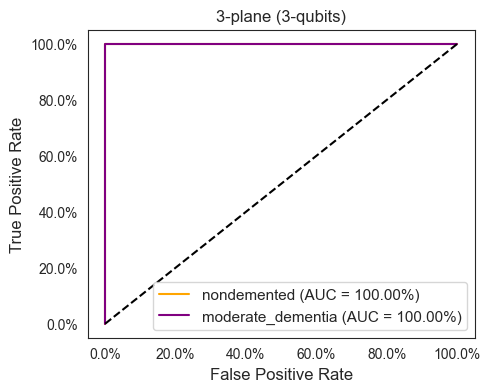

In [24]:
# Set Seaborn style
sns.set_style("white")

fig, ax = plt.subplots(figsize=(5, 4))

# Compute the ROC curve and AUC for each class
fpr_pos_cls, tpr_pos_cls, _ = roc_curve(y_true[:, pos_cls], y_pred[:, pos_cls])
auc_pos_cls = auc(fpr_pos_cls, tpr_pos_cls)

fpr_neg_cls, tpr_neg_cls, _ = roc_curve(y_true[:, neg_cls], y_pred[:, neg_cls])
auc_neg_cls = auc(fpr_neg_cls, tpr_neg_cls)

# Plot the ROC curves
ax.plot(fpr_pos_cls, tpr_pos_cls, color="orange", label=f"nondemented (AUC = {auc_pos_cls:.2%})")
ax.plot(fpr_neg_cls, tpr_neg_cls, color="purple", label=f"moderate_dementia (AUC = {auc_neg_cls:.2%})")

# Customize the ticks and labels on the axes
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=1))

# Add the diagonal line, labels, title, and legend
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate", fontsize='12')
plt.ylabel("True Positive Rate", fontsize='12')
plt.title("3-plane (3-qubits)", fontsize='12')
plt.legend(fontsize='11')
plt.show()

In [25]:
############## Classification Report ##############
targetnames = ['2', '3']

report = classification_report(y_true_flat, y_pred_flat, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           2       1.00      0.99      1.00       104
           3       0.99      1.00      1.00       100

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



In [26]:
TN, FP, FN, TP = confusion_matrix(y_true_flat, y_pred_flat).ravel()

sensitivity = '{0:.2f}'.format(TP/(TP+FN)*100)
specificity = '{0:.2f}'.format(TN/(TN+FP)*100)
    
precision = '{0:.2f}'.format(precision_score(y_true_flat, y_pred_flat)*100)
recall = '{0:.2f}'.format(recall_score(y_true_flat, y_pred_flat)*100)
f1 = '{0:.2f}'.format(f1_score(y_true_flat, y_pred_flat)*100)
accuracy = '{0:.2f}'.format(accuracy_score(y_true_flat, y_pred_flat)*100)

matrix_log = [[precision, recall, f1, accuracy, sensitivity, specificity, TN, FP, FN, TP]]
df_result = pd.DataFrame(
    matrix_log, 
    columns=[
        'Precision (%)',
        'Recall (%)', 
        'F1-Score (%)',
        'Accuracy (%)', 
        'Sensitivity (%)', 
        'Specificity (%)',
        'TN',
        'FP', 
        'FN', 
        'TP'
    ])

df_result = df_result.style.hide(axis='index')
df_result

Precision (%),Recall (%),F1-Score (%),Accuracy (%),Sensitivity (%),Specificity (%),TN,FP,FN,TP
99.01,100.00,99.50,99.51,100.00,99.04,103,1,0,100


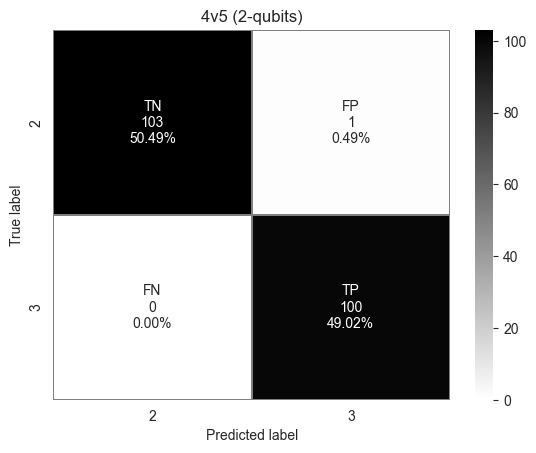

In [27]:
cnf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cnf_matrix.flatten()/np.sum(cnf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

matrix_labels = np.asarray(labels).reshape(2,2)
axis_labels = ['2', '3']

ax = sns.heatmap(
    cnf_matrix, 
    annot=matrix_labels, 
    fmt='',  
    cmap='binary', 
    linewidths=0.1, 
    linecolor='gray',
    xticklabels=axis_labels, 
    yticklabels=axis_labels
)

sns_figure = ax.set(xlabel='Predicted label', ylabel='True label', title='4v5 (2-qubits)')